In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler,OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.feature_selection import VarianceThreshold 

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


In [2]:
data = pd.read_csv('data_with_predictions.csv')
data

,STATE,CLUSTER,HOMEOWNR,GENDER,DATASRCE,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B,...,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,TARGET_B,TARGET_D,TARGET_B_PRED
0,IL,36,H,F,3,L,E,C,T,2,...,10.0,4,7.741935,95515,0,4,39,0,0.0,0
1,CA,14,H,M,3,L,G,A,S,1,...,25.0,18,15.666667,148535,0,2,1,0,0.0,0
2,NC,43,U,M,3,L,E,C,R,2,...,5.0,12,7.481481,15078,1,4,60,0,0.0,0
3,CA,44,U,F,3,L,E,C,R,2,...,10.0,9,6.812500,172556,1,4,41,0,0.0,0
4,FL,16,H,F,3,L,F,A,S,2,...,15.0,14,6.864865,7112,1,2,26,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,other,27,H,M,3,L,G,C,C,2,...,25.0,9,25.000000,184568,0,1,12,0,0.0,0
95408,TX,24,H,M,3,L,F,A,C,1,...,20.0,9,20.000000,122706,1,1,2,0,0.0,0
95409,MI,30,H,M,3,L,E,B,C,3,...,10.0,3,8.285714,189641,1,3,34,0,0.0,0
95410,CA,24,H,F,2,L,F,A,C,1,...,18.0,4,12.146341,4693,1,4,11,1,18.0,1


In [3]:
y = data.iloc[:, -2]
X = data.iloc[:, :-1]
X.drop(columns=['TARGET_B'], inplace=True)
X

,STATE,CLUSTER,HOMEOWNR,GENDER,DATASRCE,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B,...,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,TARGET_D
0,IL,36,H,F,3,L,E,C,T,2,...,5.0,12.0,10.0,4,7.741935,95515,0,4,39,0.0
1,CA,14,H,M,3,L,G,A,S,1,...,10.0,25.0,25.0,18,15.666667,148535,0,2,1,0.0
2,NC,43,U,M,3,L,E,C,R,2,...,2.0,16.0,5.0,12,7.481481,15078,1,4,60,0.0
3,CA,44,U,F,3,L,E,C,R,2,...,2.0,11.0,10.0,9,6.812500,172556,1,4,41,0.0
4,FL,16,H,F,3,L,F,A,S,2,...,3.0,15.0,15.0,14,6.864865,7112,1,2,26,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,other,27,H,M,3,L,G,C,C,2,...,25.0,25.0,25.0,9,25.000000,184568,0,1,12,0.0
95408,TX,24,H,M,3,L,F,A,C,1,...,20.0,20.0,20.0,9,20.000000,122706,1,1,2,0.0
95409,MI,30,H,M,3,L,E,B,C,3,...,3.0,10.0,10.0,3,8.285714,189641,1,3,34,0.0
95410,CA,24,H,F,2,L,F,A,C,1,...,5.0,21.0,18.0,4,12.146341,4693,1,4,11,18.0


In [4]:
# Filter out numerical and cat columns
numerical_data = X.select_dtypes(include=['number'])
print(numerical_data.shape)
# categorical_features = data.select_dtypes(include=['object'])

# Calculate the correlation
correlation_matrix = numerical_data.corr()

# Extract the correlation of features with the target variable
target_correlation = correlation_matrix['TARGET_D'].sort_values(ascending=False)

(95412, 331)


In [5]:
# Calculate correlation of features with the target
correlation_with_target = correlation_matrix['TARGET_D'].abs()

# Remove features with correlation <= 0.02 with the target
selected_features = correlation_with_target[correlation_with_target > 0.03].index

# Get correlation matrix of selected features
selected_corr_matrix = correlation_matrix.loc[selected_features, selected_features]

# Find pairs of highly correlated features
highly_correlated_pairs = set()
for col in selected_corr_matrix.columns:
    correlated_cols = selected_corr_matrix[selected_corr_matrix[col] > 0.7].index.tolist()
    for correlated_col in correlated_cols:
        if col != correlated_col:
            pair = tuple(sorted([col, correlated_col]))
            highly_correlated_pairs.add(pair)

In [6]:
highly_correlated_pairs

{('AVGGIFT', 'LASTGIFT'),
 ('AVGGIFT', 'MAXRAMNT'),
 ('EC8', 'IC4'),
 ('HV1', 'HV2'),
 ('HV1', 'HV3'),
 ('HV1', 'HV4'),
 ('HV1', 'HVP1'),
 ('HV1', 'HVP2'),
 ('HV1', 'HVP3'),
 ('HV1', 'HVP4'),
 ('HV1', 'HVP6'),
 ('HV1', 'IC2'),
 ('HV1', 'IC3'),
 ('HV1', 'IC4'),
 ('HV1', 'IC5'),
 ('HV2', 'HV3'),
 ('HV2', 'HV4'),
 ('HV2', 'HVP1'),
 ('HV2', 'HVP2'),
 ('HV2', 'HVP3'),
 ('HV2', 'HVP4'),
 ('HV2', 'HVP6'),
 ('HV2', 'IC2'),
 ('HV2', 'IC3'),
 ('HV2', 'IC4'),
 ('HV2', 'IC5'),
 ('HV3', 'HV4'),
 ('HV3', 'HVP2'),
 ('HV3', 'HVP3'),
 ('HV3', 'HVP4'),
 ('HV3', 'IC1'),
 ('HV3', 'IC2'),
 ('HV3', 'IC3'),
 ('HV3', 'IC4'),
 ('HV3', 'RP2'),
 ('HV4', 'HVP2'),
 ('HV4', 'HVP3'),
 ('HV4', 'HVP4'),
 ('HV4', 'IC3'),
 ('HV4', 'RP2'),
 ('HVP1', 'HVP2'),
 ('HVP1', 'HVP3'),
 ('HVP1', 'HVP6'),
 ('HVP2', 'HVP3'),
 ('HVP2', 'HVP4'),
 ('HVP2', 'HVP6'),
 ('HVP3', 'HVP4'),
 ('HVP3', 'IC4'),
 ('HVP3', 'RP2'),
 ('HVP4', 'IC3'),
 ('HVP4', 'IC4'),
 ('HVP4', 'RP2'),
 ('IC1', 'IC2'),
 ('IC1', 'IC3'),
 ('IC1', 'IC4'),
 ('IC1', 'IC

In [7]:
# Initialize a set to store features to drop
features_to_drop = set()

# Drop features with least correlation with the target among highly correlated pairs
for pair in highly_correlated_pairs:
    corr1 = correlation_with_target[pair[0]]
    corr2 = correlation_with_target[pair[1]]
    if corr1 < corr2:
        features_to_drop.add(pair[0])
    else:
        features_to_drop.add(pair[1])

# Drop the selected features from the set
selected_features = selected_features.drop(features_to_drop, errors='ignore')

In [8]:
len(selected_features)

4

In [9]:
numerical_data = numerical_data[selected_features]
numerical_data

,HV2,RAMNTALL,LASTGIFT,TARGET_D
0,635,240.0,10.0,0.0
1,5218,47.0,25.0,0.0
2,546,202.0,5.0,0.0
3,1263,109.0,10.0,0.0
4,594,254.0,15.0,0.0
...,...,...,...,...
95407,1025,25.0,25.0,0.0
95408,1723,20.0,20.0,0.0
95409,377,58.0,10.0,0.0
95410,2459,498.0,18.0,18.0


In [10]:
correlation_matrix = numerical_data.corr()

In [11]:
correlation_with_target = correlation_matrix['TARGET_D'].abs()
correlation_with_target

HV2         0.039860
RAMNTALL    0.044810
LASTGIFT    0.061678
TARGET_D    1.000000
Name: TARGET_D, dtype: float64

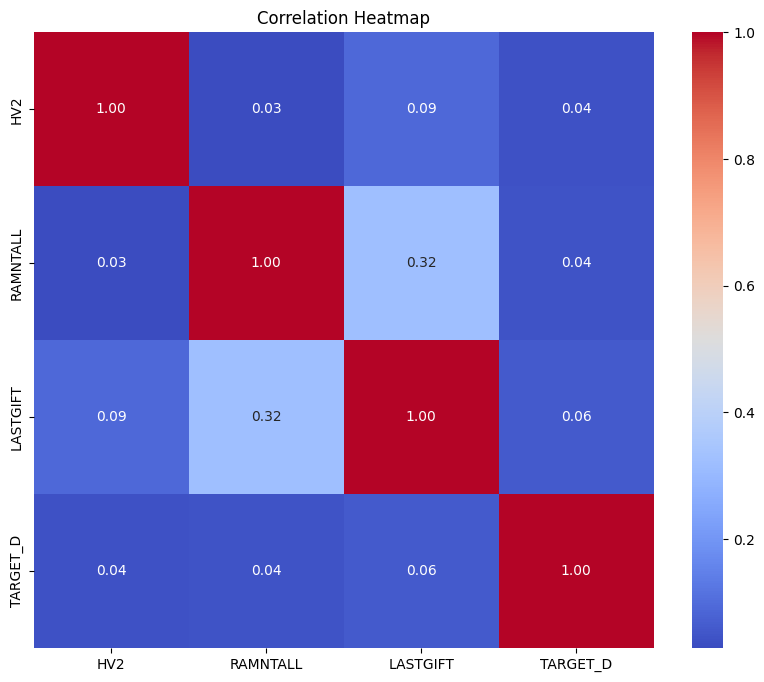

In [12]:
correlation_matrix = numerical_data.corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

>> check categoricals, drop with cardinality

In [13]:
# Select categorical columns
categorical_data = data.select_dtypes(include='object')

# Calculate the number of unique values in each categorical variable
unique_value_counts = categorical_data.nunique()

# Get the names of categorical columns with cardinality greater than 15
high_cardinality_columns = unique_value_counts[unique_value_counts > 15].index.tolist()

# Drop the columns with high cardinality from the DataFrame
categorical_data = categorical_data.drop(columns=high_cardinality_columns)
categorical_data

,STATE,HOMEOWNR,GENDER,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A
0,IL,H,F,L,E,C,T
1,CA,H,M,L,G,A,S
2,NC,U,M,L,E,C,R
3,CA,U,F,L,E,C,R
4,FL,H,F,L,F,A,S
...,...,...,...,...,...,...,...
95407,other,H,M,L,G,C,C
95408,TX,H,M,L,F,A,C
95409,MI,H,M,L,E,B,C
95410,CA,H,F,L,F,A,C


> check data

In [14]:
display(numerical_data)
display(categorical_data)

,HV2,RAMNTALL,LASTGIFT,TARGET_D
0,635,240.0,10.0,0.0
1,5218,47.0,25.0,0.0
2,546,202.0,5.0,0.0
3,1263,109.0,10.0,0.0
4,594,254.0,15.0,0.0
...,...,...,...,...
95407,1025,25.0,25.0,0.0
95408,1723,20.0,20.0,0.0
95409,377,58.0,10.0,0.0
95410,2459,498.0,18.0,18.0


,STATE,HOMEOWNR,GENDER,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A
0,IL,H,F,L,E,C,T
1,CA,H,M,L,G,A,S
2,NC,U,M,L,E,C,R
3,CA,U,F,L,E,C,R
4,FL,H,F,L,F,A,S
...,...,...,...,...,...,...,...
95407,other,H,M,L,G,C,C
95408,TX,H,M,L,F,A,C
95409,MI,H,M,L,E,B,C
95410,CA,H,F,L,F,A,C


In [15]:
# concat 
data = pd.concat([numerical_data, categorical_data], axis=1)
data

,HV2,RAMNTALL,LASTGIFT,TARGET_D,STATE,HOMEOWNR,GENDER,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A
0,635,240.0,10.0,0.0,IL,H,F,L,E,C,T
1,5218,47.0,25.0,0.0,CA,H,M,L,G,A,S
2,546,202.0,5.0,0.0,NC,U,M,L,E,C,R
3,1263,109.0,10.0,0.0,CA,U,F,L,E,C,R
4,594,254.0,15.0,0.0,FL,H,F,L,F,A,S
...,...,...,...,...,...,...,...,...,...,...,...
95407,1025,25.0,25.0,0.0,other,H,M,L,G,C,C
95408,1723,20.0,20.0,0.0,TX,H,M,L,F,A,C
95409,377,58.0,10.0,0.0,MI,H,M,L,E,B,C
95410,2459,498.0,18.0,18.0,CA,H,F,L,F,A,C


In [16]:
selected_columns = data.columns.tolist()
selected_columns

['HV2',
 'RAMNTALL',
 'LASTGIFT',
 'TARGET_D',
 'STATE',
 'HOMEOWNR',
 'GENDER',
 'RFA_2R',
 'RFA_2A',
 'GEOCODE2',
 'DOMAIN_A']

> filter data on TARGET_B

In [17]:
data = pd.read_csv('data_with_predictions.csv', usecols=selected_columns + ['TARGET_B_PRED'])
data = data[data['TARGET_B_PRED'] == 1]
data.drop(columns=['TARGET_B_PRED'], inplace=True)
data.reset_index(drop=True, inplace=True)
data

,STATE,HOMEOWNR,GENDER,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,HV2,RAMNTALL,LASTGIFT,TARGET_D
0,other,H,F,L,D,A,S,960,61.00,5.0,4.0
1,TX,H,M,L,D,A,T,1166,68.00,7.0,7.0
2,other,H,F,L,D,C,C,1399,102.00,5.0,5.0
3,CA,H,F,L,F,A,S,5471,132.00,10.0,13.0
4,GA,H,M,L,E,A,S,698,94.00,12.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...
4830,CA,H,F,L,F,A,T,752,238.07,17.0,20.0
4831,CA,H,F,L,F,B,S,1692,35.00,15.0,15.0
4832,WI,H,F,L,G,B,S,975,144.00,20.0,3.0
4833,other,H,F,L,F,D,R,606,139.00,20.0,10.0


> train-test-split

In [18]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['TARGET_D'])  
y = data['TARGET_D']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
X_train_num = X_train.select_dtypes(np.number)
X_test_num = X_test.select_dtypes(np.number)
X_train_cat = X_train.select_dtypes(object) 
X_test_cat = X_test.select_dtypes(object) 

In [20]:
# Scale numerical features
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num), columns=X_train_num.columns)

# Encode categorical features
encoder = OrdinalEncoder()
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train_cat), columns=X_train_cat.columns)
X_test_encoded = pd.DataFrame(encoder.transform(X_test_cat), columns=X_test_cat.columns)

X_train=pd.concat([X_train_scaled, X_train_encoded],axis=1)
X_test=pd.concat([X_test_scaled,X_test_encoded],axis=1)

>> finding the best model

In [21]:
max_depth = range(1,30)
test = []
train = []

for depth in max_depth:
    model = RandomForestRegressor(max_depth=depth, random_state=0)
    model.fit(X_train, y_train)
    test.append(model.score(X_test,y_test))
    train.append(model.score(X_train,y_train))

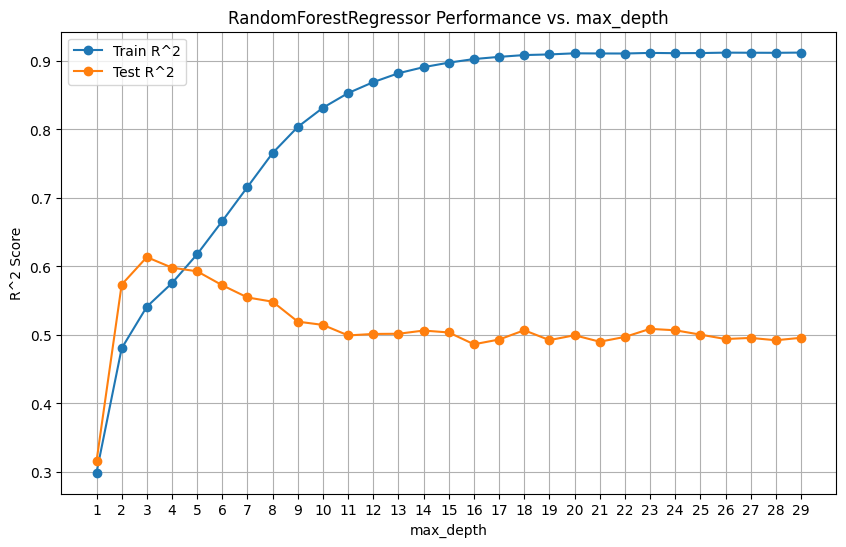

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(max_depth, train, label='Train R^2', marker='o')
plt.plot(max_depth, test, label='Test R^2', marker='o')
plt.xlabel('max_depth')
plt.ylabel('R^2 Score')
plt.title('RandomForestRegressor Performance vs. max_depth')
plt.xticks(max_depth)
plt.legend()
plt.grid(True)
plt.show()

In [24]:
model_list=[LinearRegression(),KNeighborsRegressor(),DecisionTreeRegressor(max_depth=5),RandomForestRegressor(max_depth=3)]

In [25]:
def get_model_scored(models, X_tr, y_tr,X_te, y_te):
    for model in models:
        model.fit(X_tr, y_tr)
        print(f"{model.__class__.__name__}: Train: {model.score(X_tr, y_tr)}, Test: {model.score(X_te, y_te)}")

In [26]:
get_model_scored(model_list,X_train,y_train,X_test,y_test)

LinearRegression: Train: 0.4716944748628019, Test: 0.6149145084720407
KNeighborsRegressor: Train: 0.5178162693176351, Test: 0.37577766444012095
DecisionTreeRegressor: Train: 0.6234455415895859, Test: 0.5396922103994393
RandomForestRegressor: Train: 0.5431068766089489, Test: 0.611191268988968


LinearRegression: Train: 0.4716944748628019, Test: 0.6149145084720407  
KNeighborsRegressor: Train: 0.5178162693176351, Test: 0.37577766444012095  
DecisionTreeRegressor: Train: 0.6234455415895859, Test: 0.5396922103994393  
**RandomForestRegressor: Train: 0.5431068766089489, Test: 0.611191268988968**  

>> Random Forest

>>> max depth 5!

In [27]:
model = RandomForestRegressor(max_depth=5, random_state=0)
model.fit(X_train, y_train)
print(model.score(X_test,y_test))
print(model.score(X_train,y_train))

0.5928922443312532
0.6177840811918189


> cross validation with linear

In [28]:
def validate_model(models, X_tr, y_tr):
    for model in models:
        results= cross_validate(model,X_tr,y_tr,cv=5)
        print(f"Results for {model.__class__.__name__}:")
        print('Test scores: ', results['test_score'])
        print('Mean:', results['test_score'].mean(), '\n')

In [30]:
model_list=[LinearRegression(),RandomForestRegressor(max_depth=5)]
validate_model(model_list,X_train,y_train)

Results for LinearRegression:
Test scores:  [0.5282071  0.01221857 0.50914588 0.44779335 0.44155808]
Mean: 0.3877845964560102 

Results for RandomForestRegressor:
Test scores:  [0.5133778  0.5056206  0.42852676 0.42278252 0.43527414]
Mean: 0.4611163645484878 



> random is higher on average + more stable 

> create model

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Instantiate RandomForestRegressor with optional hyperparameters
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

# Fit the model to the training data
rf_regressor.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = rf_regressor.predict(X_test_scaled)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("R-squared:", r2)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)


R-squared: 0.5909496880207361
Mean Absolute Error: 3.8055044029202896
Root Mean Squared Error: 6.383663539320184


create model on all data! 

In [41]:
data = pd.read_csv('data_with_predictions.csv', usecols=selected_columns + ['TARGET_B_PRED'])
data = data[data['TARGET_B_PRED'] == 1]
data.drop(columns=['TARGET_B_PRED'], inplace=True)
data.reset_index(drop=True, inplace=True)
data

,STATE,HOMEOWNR,GENDER,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,HV2,RAMNTALL,LASTGIFT,TARGET_D
0,other,H,F,L,D,A,S,960,61.00,5.0,4.0
1,TX,H,M,L,D,A,T,1166,68.00,7.0,7.0
2,other,H,F,L,D,C,C,1399,102.00,5.0,5.0
3,CA,H,F,L,F,A,S,5471,132.00,10.0,13.0
4,GA,H,M,L,E,A,S,698,94.00,12.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...
4830,CA,H,F,L,F,A,T,752,238.07,17.0,20.0
4831,CA,H,F,L,F,B,S,1692,35.00,15.0,15.0
4832,WI,H,F,L,G,B,S,975,144.00,20.0,3.0
4833,other,H,F,L,F,D,R,606,139.00,20.0,10.0


In [42]:
X = data.drop(columns=['TARGET_D'])  
y = data['TARGET_D'] 

numerical_features = X.select_dtypes(include=['int', 'float']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Split the data into numerical and categorical dataframes
X_numerical = X[numerical_features]
X_categorical = X[categorical_features]

In [56]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Instantiate a new scaler
target_d_scaler = StandardScaler()

# Fit and transform the numerical features
X_numerical_scaled = target_d_scaler.fit_transform(X_numerical)

# Instantiate a new encoder
target_d_encoder = OneHotEncoder(sparse=False, drop='first')  # Assuming you want to drop the first column to avoid multicollinearity

# Fit and transform the categorical features
X_categorical_encoded = target_d_encoder.fit_transform(X_categorical)

# Convert the encoded array to a DataFrame
X_categorical_encoded_df = pd.DataFrame(X_categorical_encoded, columns=target_d_encoder.get_feature_names_out())

# Concatenate the scaled numerical features and encoded categorical features
X_scaled_encoded = pd.concat([pd.DataFrame(X_numerical_scaled, columns=X_numerical.columns), X_categorical_encoded_df], axis=1)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [57]:
X_scaled_encoded

,HV2,RAMNTALL,LASTGIFT,STATE_FL,STATE_GA,STATE_IL,STATE_IN,STATE_MI,STATE_MO,STATE_NC,...,RFA_2A_E,RFA_2A_F,RFA_2A_G,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D,DOMAIN_A_R,DOMAIN_A_S,DOMAIN_A_T,DOMAIN_A_U
0,-0.269166,-0.466961,-0.751349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.070181,-0.402361,-0.603529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.154884,-0.088592,-0.751349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4.088209,0.188263,-0.381799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.522243,-0.162420,-0.233979,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,-0.470082,1.167131,0.135571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4831,0.437906,-0.706902,-0.012249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4832,-0.254676,0.299005,0.357302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4833,-0.611110,0.252863,0.357302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [54]:
model_file_path = 'd_random_forest_regressor_model.pkl'
scaler_file_path = 'd_scaler.pkl'
encoder_file_path = 'd_encoder.pkl'

# Pickle the trained model
with open(model_file_path, 'wb') as file:
    pickle.dump(rf_regressor, file)
    
# Pickle the scaler
with open(scaler_file_path, 'wb') as file:
    pickle.dump(scaler, file)

# Pickle the encoder
with open(encoder_file_path, 'wb') as file:
    pickle.dump(encoder, file)

In [55]:
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
# Train the model using the scaled and encoded features
rf_regressor.fit(X_scaled_encoded, y)

RandomForestRegressor(max_depth=5, random_state=42)

> use on data

In [100]:
data = pd.read_csv('data_with_predictions.csv', usecols=selected_columns + ['TARGET_B_PRED'])
original_data = data
data = data[data['TARGET_B_PRED'] == 1]
data_with_predictions = data.copy()
data.drop(columns=['TARGET_B_PRED'], inplace=True)
data.reset_index(drop=True, inplace=True)
X = data.drop(columns=['TARGET_D'])  

numerical_features = X.select_dtypes(include=['int', 'float']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Split the data into numerical and categorical dataframes
X_numerical = X[numerical_features]
X_categorical = X[categorical_features]

/var/folders/pr/f4jl4tln3yn9fd_1yjrwwkp40000gn/T/ipykernel_81835/2207630969.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['TARGET_B_PRED'], inplace=True)


In [82]:
# Fit and transform the numerical features
X_numerical_scaled = target_d_scaler.transform(X_numerical)

# Fit and transform the categorical features
X_categorical_encoded = target_d_encoder.transform(X_categorical)

# Convert the encoded array to a DataFrame
X_categorical_encoded_df = pd.DataFrame(X_categorical_encoded, columns=target_d_encoder.get_feature_names_out())

# Concatenate the scaled numerical features and encoded categorical features
X_scaled_processed = pd.concat([pd.DataFrame(X_numerical_scaled, columns=X_numerical.columns), X_categorical_encoded_df], axis=1)

In [86]:
# Make predictions on the training data
predictions = rf_regressor.predict(X_scaled_processed)

# Add predictions as a new column to the original DataFrame
data_with_predictions['TARGET_D_PRED'] = predictions

In [94]:
# Calculate the mean of the actual target column 'TARGET_D'
mean_target_d = data_with_predictions['TARGET_D'].mean()

# Calculate the mean of the predicted target column 'TARGET_D_PRED'
mean_target_d_pred = data_with_predictions['TARGET_D_PRED'].mean()

print("Mean of TARGET_D:", mean_target_d)
print("Mean of TARGET_D_PRED:", mean_target_d_pred)

Mean of TARGET_D: 15.615449844881075
Mean of TARGET_D_PRED: 15.622860467000063


In [99]:
data_with_predictions[['TARGET_D','TARGET_D_PRED']].describe()

,TARGET_D,TARGET_D_PRED
count,4835.000000,4835.000000
mean,15.615450,15.622860
std,12.445166,9.296423
min,1.000000,5.895284
25%,10.000000,10.699896
50%,13.000000,15.349201
75%,20.000000,18.889850
max,200.000000,154.834532


In [96]:
(len(data_with_predictions))

4835

In [95]:
data_with_predictions['TARGET_D_PRED'].sum() - (len(data_with_predictions) * 0.68)

72248.7303579453

In [106]:
original_data['TARGET_D'].sum() - len(original_data) * 0.68

10788.539999999994